# 🔍 SciPy Solver Analyzer

This notebook analyzes how different solver **methods** and **parameter settings** (`rtol`, `atol`, `max_step`) affect:
- **Accuracy** (via RMSE)
- **Runtime**
on a fixed ODE system.

We explore:
1. Varying solver **parameters** for a fixed method.
2. Varying solver **methods** for fixed parameters.


In [190]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import pandas as pd

########## Non Stiff ODEs for Testing Numerical Solvers ###########
# True solution for comparison (logistic ODE)
def logistic_exact(t, r=0.1, K=1, y0=2):
    return K / (1 + ((K - y0) / y0) * np.exp(-r * t))

# Define ODE: logistic growth
def logistic(t, y, r=0.1, K=1):
    return [r * y[0] * (1 - y[0] / K)]

y0 = [2]
t_span = (0, 50)
t_eval = np.linspace(*t_span, 500)
true_y = logistic_exact(t_eval)

######## ODEs for Testing Numerical Solvers ###########
# stiffness depends on coefficients
# ODE function (used in solver, not for analytical derivative)
def ode_harmonic_oscillator(t, y, omega=1*np.pi):
    '''
    d^2y/dt^2 + omega^2 * y(t) = 0
    This is a second-order ODE that can be rewritten as a system of first-order O
    by introducing y(t) = y0(position) and dy/dt = y1(velocity).
    Thus, we have:
    dy0/dt = y1
    dy1/dt = -omega^2 * y0

    t is array of time points
    y is array of [y0, y1] where:
        y0 is position
        y1 is velocity

    '''
    dy0_dt = y[1]
    dy1_dt = -omega**2 * y[0]
    return [dy0_dt, dy1_dt]

# Analytical solution
def true_solution_harmonic_oscillator(t, A=100, B=0.0, omega=1*np.pi):
    return A * np.cos(omega * t) + B * np.sin(omega * t)

# Analytical first derivative (velocity)
def true_velocity(t, A=100, B=0.0, omega=1*np.pi):
    return -A * omega * np.sin(omega * t) + B * omega * np.cos(omega * t)

#####################
def simple_stiff(t, y, k1=3.0, k2=0.5):
    y1, y2 = y
    dy1 = -k1 * y1
    dy2 = -k2 * y2
    return np.array([dy1, dy2]) 

def true_simple_stiff(t, y0=[1.0, 1.0], k1=3.0, k2=0.5):
    y1 = y0[0] * np.exp(-k1 * t)
    y2 = y0[1] * np.exp(-k2 * t)
    return np.stack([y1, y2], axis=0)



ode_system = simple_stiff
if ode_system == logistic:
    y0 = [2]
    t_span = (0, 50)
    t_eval = np.linspace(*t_span, 500)
    true_y = logistic_exact(t_eval)
elif ode_system == ode_harmonic_oscillator:
    y0 = [100, 0.0]  # Initial conditions: [position, velocity]
    t_span = [0, 2]
    t_eval = np.linspace(t_span[0], t_span[1], 100000)
    true_y = true_solution_harmonic_oscillator(t_eval, A=100, B=0.0, omega=1*np.pi)
elif ode_system == simple_stiff:
    y0 = [1.0, 1.0]
    t_span = (0, 20)
    t_eval = np.linspace(*t_span, 10000)
    true_y = true_simple_stiff(t_eval)

In [191]:
def evaluate_solver(ode_system, method, rtol=1e-6, atol=1e-9):
    start = time.perf_counter()
    sol = solve_ivp(ode_system, t_span, y0, method=method, t_eval=t_eval, rtol=rtol, atol=atol)
    runtime = time.perf_counter() - start
    # print(sol.y.shape[0])
    # print(sol.y[0])
    # print(true_y)
    if ode_system == simple_stiff:
        diff = true_y - sol.y
    elif sol.y.shape[0] > 1:
        diff = true_y - sol.y[0]
    else:
        diff = true_y - sol.y

    if diff.ndim == 1:
        rmse = np.sqrt(np.mean(diff ** 2))
    else:
        rmse = np.sqrt(np.mean(diff ** 2, axis=1)).mean()
    # rmse = np.sqrt(np.mean((true_y - sol.y) ** 2, axis=1)).mean()
    return {
        "method": method,
        "rtol": rtol,
        "atol": atol,
        "nfev": sol.nfev,
        "n_steps": len(sol.t),
        "rmse": rmse,
        "runtime_sec": runtime,
        "solution": sol
    }


## Experiment 1: Fixed Method (`Radau`), Vary Parameters

In [192]:
param_grid = [
    {"rtol": 1e-1, "atol": 1e-1},
    {"rtol": 1e-3, "atol": 1e-6},
    {"rtol": 1e-6, "atol": 1e-9},
    {"rtol": 1e-9, "atol": 1e-12},
]

results_param_variation = []
for params in param_grid:
    result = evaluate_solver(ode_system, method='Radau', rtol=params["rtol"], atol=params["atol"])
    results_param_variation.append(result)

df_param = pd.DataFrame(results_param_variation)
df_param[["method", "rtol", "atol", "rmse", "runtime_sec", "nfev"]]


,method,rtol,atol,rmse,runtime_sec,nfev
0,Radau,1.000000e-01,1.000000e-01,8.866560e-04,0.004404,44
1,Radau,1.000000e-03,1.000000e-06,4.986625e-06,0.016131,205
2,Radau,1.000000e-06,1.000000e-09,5.429081e-09,0.069069,1100
3,Radau,1.000000e-09,1.000000e-12,5.314735e-12,0.321561,6231


## Experiment 2: Fixed Parameters, Vary Methods

In [193]:
methods = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
results_method_variation = []
for method in methods:
    result = evaluate_solver(ode_system, method=method, rtol=1e-2, atol=1e-2)
    results_method_variation.append(result)

df_method = pd.DataFrame(results_method_variation)
df_method[["method", "rmse", "runtime_sec", "nfev"]]


,method,rmse,runtime_sec,nfev
0,RK45,0.002998,0.003997,134
1,RK23,0.007684,0.005922,104
2,DOP853,0.046947,0.005920,215
3,Radau,0.000161,0.005322,65
4,BDF,0.002056,0.012169,62
5,LSODA,0.000956,0.005380,79


## 📊 Results Visualization

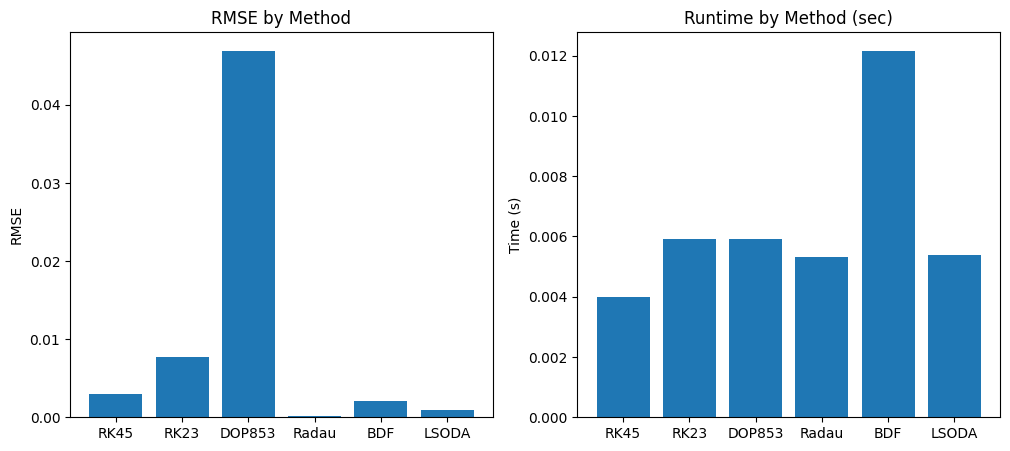

In [194]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(df_method["method"], df_method["rmse"])
axs[0].set_title("RMSE by Method")
axs[0].set_ylabel("RMSE")
axs[1].bar(df_method["method"], df_method["runtime_sec"])
axs[1].set_title("Runtime by Method (sec)")
axs[1].set_ylabel("Time (s)")
plt.show()


(10000,)
(2, 10000)


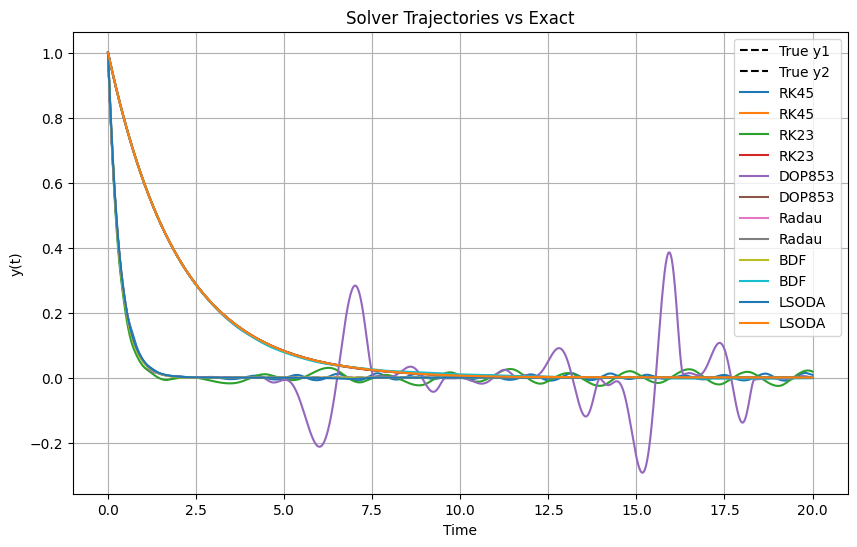

In [ ]:
plt.figure(figsize=(10,6))
print(t_eval.shape)
print(true_y.shape)
if ode_system == simple_stiff:
    for i in range(true_y.shape[0]):
        plt.plot(t_eval, true_y[i], 'k--', label=f'True y{i+1}')
else:
    plt.plot(t_eval, true_y, 'k--', label="Exact")

for result in results_method_variation:
    if result["method"] in ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']:
        # 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
        if ode_system == simple_stiff:
            for i in range(result["solution"].y.shape[0]):
                plt.plot(result["solution"].t, result["solution"].y[i], label=result["method"])
        else:
            print(result["solution"].y.shape)
            plt.plot(result["solution"].t, result["solution"].y[0], label=result["method"])

plt.title("Solver Trajectories vs Exact")
plt.xlabel("Time")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()
